In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import torch
# from torch.utils.data import PairTensor
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets 
import torchvision.transforms as transforms
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import copy

In [2]:
# Define paths to train and test data
data_path = '/Users/kritikasharma/Downloads/DATA_'

In [3]:
emotion_classes = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sad']

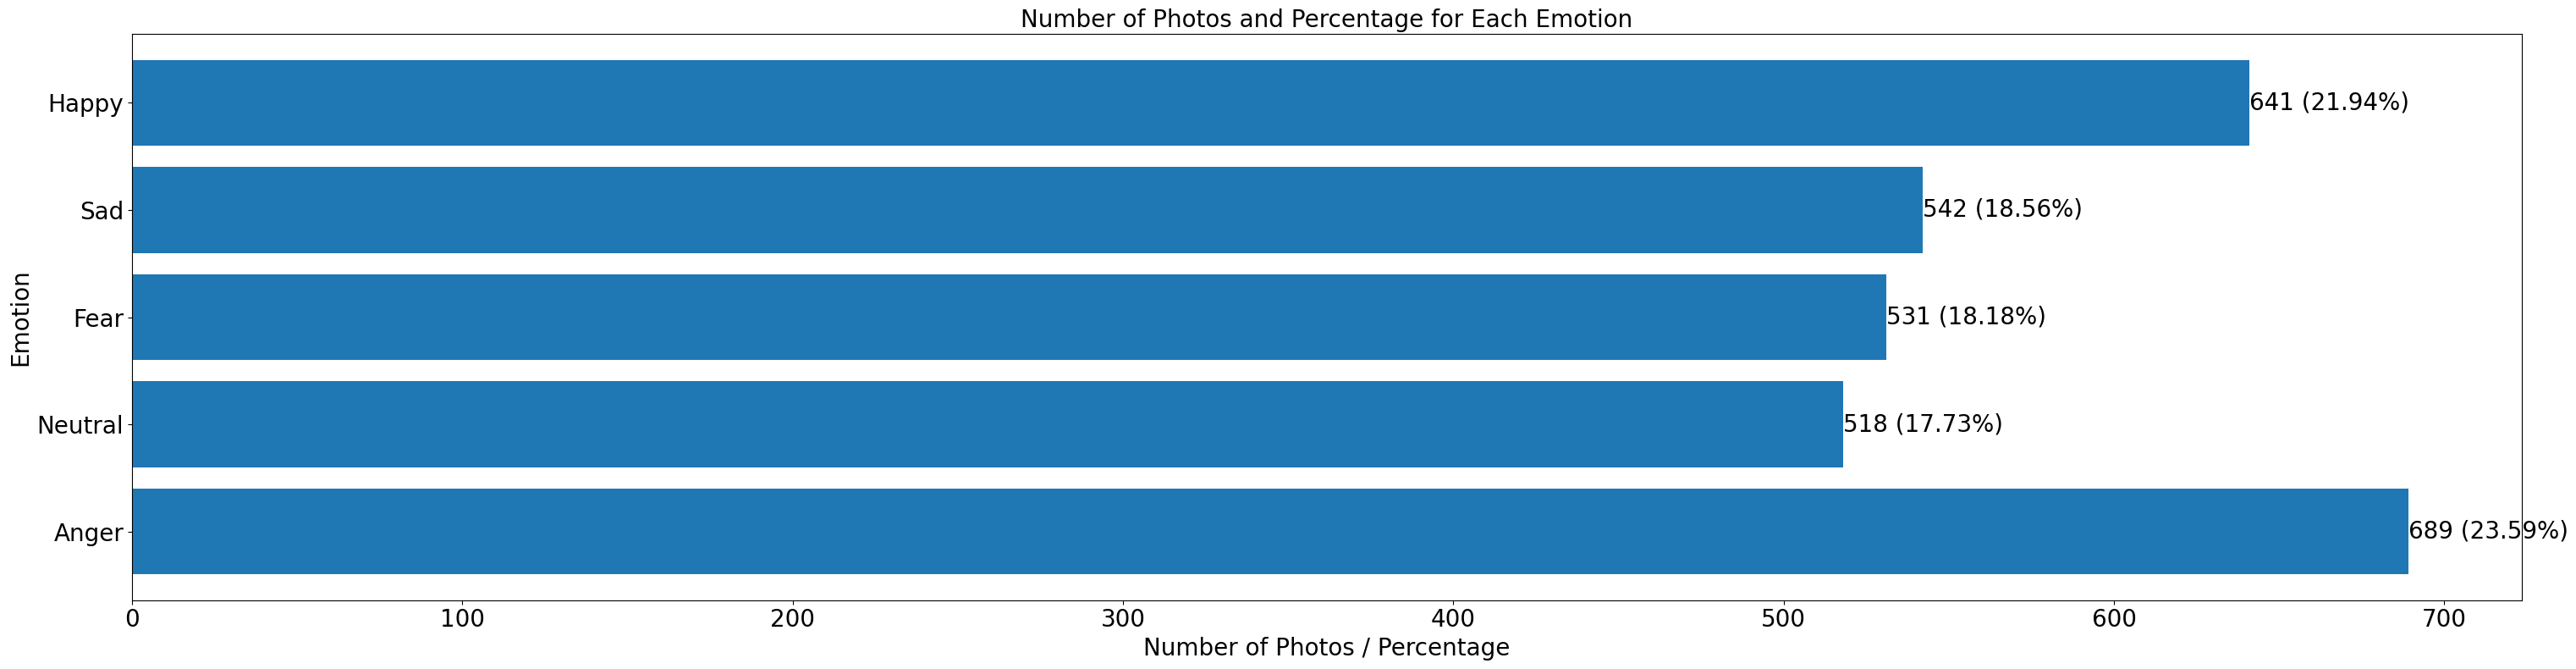

In [4]:
# Initialize an empty dictionary to store counts for each emotion
emotion_counts = {}
total_photos = 0

# Traverse through each emotion folder
for emotion in os.listdir(data_path):
    if os.path.isdir(os.path.join(data_path, emotion)):
        # Count the number of photos in the emotion folder
        num_photos = len(os.listdir(os.path.join(data_path, emotion)))
        emotion_counts[emotion] = num_photos
        total_photos += num_photos

# Calculate percentage and format string for displaying counts and percentages
emotion_info = {emotion: {'count': count, 'percentage': (count / total_photos) * 100} for emotion, count in emotion_counts.items()}

# Plotting the horizontal bar plot
plt.figure(figsize=(30, 8))
plt.barh(list(emotion_info.keys()), [info['count'] for info in emotion_info.values()], label='Count')
plt.xlabel('Number of Photos / Percentage', fontsize=20)
plt.ylabel('Emotion',fontsize=20)
plt.title('Number of Photos and Percentage for Each Emotion', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to display emotions in descending order
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

# Display the counts and percentages on the bars
for i, (emotion, info) in enumerate(emotion_info.items()):
    count = info['count']
    percentage = info['percentage']
    plt.text(count, i, f'{count} ({percentage:.2f}%)', ha='left', va='center', fontsize=20, color='black')

plt.show()

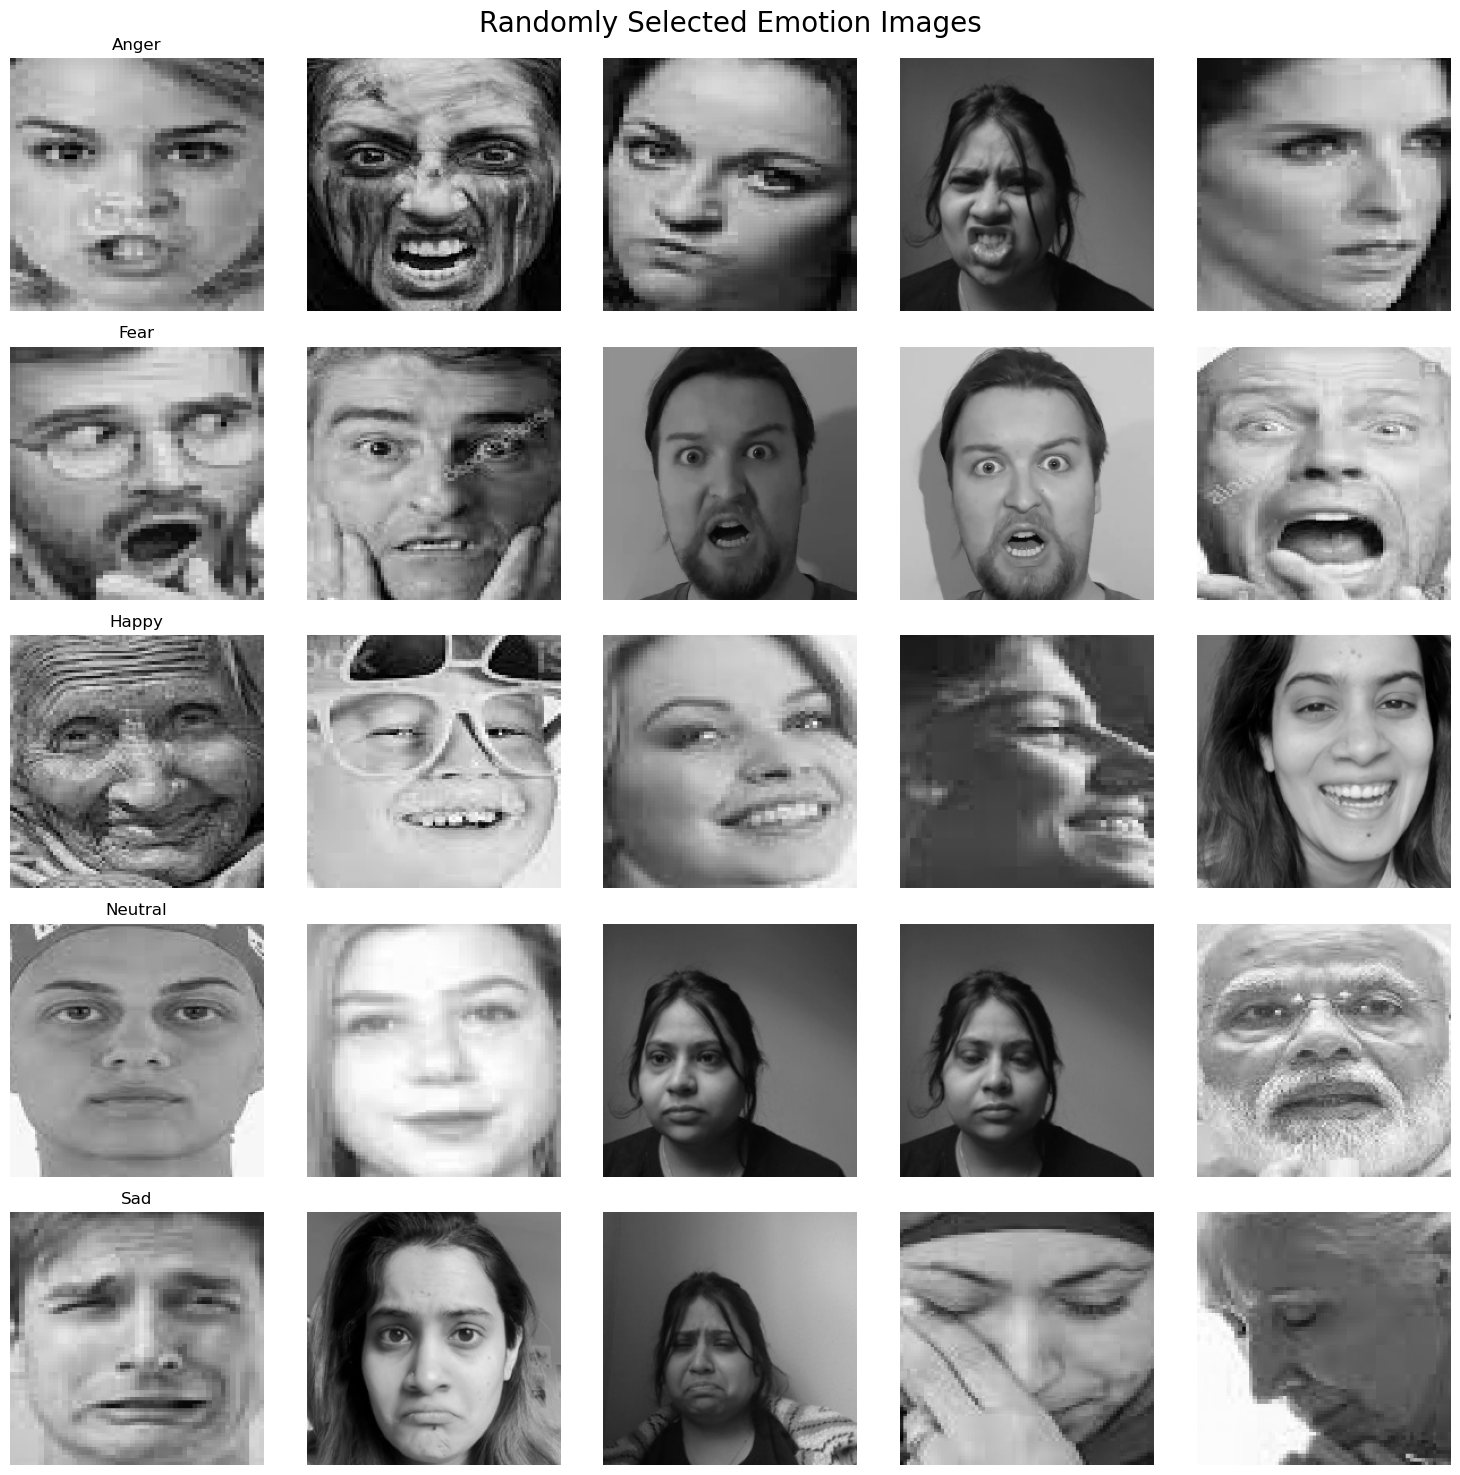

In [6]:
# Function to plot images
def plot_images(images, title):
    num_images = len(images)
    num_rows = len(emotion_classes)
    num_cols = 5  # Plot 5 images for each emotion
    plt.figure(figsize=(3 * num_cols, 3 * num_rows))
    for i, (emotion, img_paths) in enumerate(images.items()):
        for j, img_path in enumerate(img_paths[:5]):  # Plot only the first 5 images for each emotion
            plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224)) # Resize the image to a fixed size (e.g., 224x224)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the BGR image (default in OpenCV) to RGB
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(emotion)
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Randomly select 5 images from each emotion class
random_images = {emotion: [] for emotion in emotion_classes}
for emotion_class in emotion_classes:
    emotion_path = os.path.join(data_path, emotion_class)
    image_files = os.listdir(emotion_path)
    random_images[emotion_class] = random.sample([os.path.join(emotion_path, img) for img in image_files], 5)

# Plot the images
plot_images(random_images, "Randomly Selected Emotion Images")

In [7]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Append the image file paths with their respective labels to the data list
for emotion_class in emotion_classes:
    emotion_path = os.path.join(data_path, emotion_class)
    data.extend([(os.path.join(emotion_path, filename), emotion_class) for filename in os.listdir(emotion_path)])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Now let's see the first few rows of the dataframe
df.head()

,filepath,label
0,/Users/kritikasharma/Downloads/DATA_/Anger/63.jpg,Anger
1,/Users/kritikasharma/Downloads/DATA_/Anger/7v.jpg,Anger
2,/Users/kritikasharma/Downloads/DATA_/Anger/ima...,Anger
3,/Users/kritikasharma/Downloads/DATA_/Anger/ima...,Anger
4,/Users/kritikasharma/Downloads/DATA_/Anger/ima...,Anger


In [8]:
# Convert labels to numeric
label_to_index = {label: index for index, label in enumerate(emotion_classes)}
df['label'] = df['label'].map(label_to_index)
df.head()

,filepath,label
0,/Users/kritikasharma/Downloads/DATA_/Anger/63.jpg,0
1,/Users/kritikasharma/Downloads/DATA_/Anger/7v.jpg,0
2,/Users/kritikasharma/Downloads/DATA_/Anger/ima...,0
3,/Users/kritikasharma/Downloads/DATA_/Anger/ima...,0
4,/Users/kritikasharma/Downloads/DATA_/Anger/ima...,0


In [9]:
print("Total number of images in the dataset:", len(df))

Total number of images in the dataset: 2921


In [10]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [11]:
# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

Training data shape: (2336, 2)
Validation data shape: (585, 2)


In [12]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # New: Randomly rotate images
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # New: Randomly change color
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
# Define a custom dataset
class MoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path, label = self.dataframe.iloc[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
# Create training and validation datasets
train_dataset = MoodDataset(train_df, transform=train_transforms)
val_dataset = MoodDataset(val_df, transform=val_transforms)

# Create the DataLoader for training data
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)

# Create the DataLoader for validation data
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=0)

# Now you can define the dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

# Create dataloaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [15]:
# Load a pre-trained ResNet
model = models.resnet50(pretrained=True)

# Modify the classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(emotion_classes))

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, scheduler=None):
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #backward + optimize only of in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # step the scheduler on each epoch end if its not ReduceLRonPlateau
            if phase == 'train' and scheduler and not isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step()
            # For ReduceLROnPlateau, step with the validation loss
            elif phase == 'val' and scheduler and isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

    return model, history

In [19]:
# Set up dataloaders as a dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

# Train the model
trained_model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=50, scheduler=scheduler)

Epoch 1/50
----------
train Loss: 1.3495 Acc: 0.4255
val Loss: 1.0989 Acc: 0.5709

Epoch 2/50
----------
train Loss: 1.1164 Acc: 0.5655
val Loss: 0.7977 Acc: 0.6718

Epoch 3/50
----------
train Loss: 0.9997 Acc: 0.6036
val Loss: 0.7643 Acc: 0.6889

Epoch 4/50
----------
train Loss: 0.9144 Acc: 0.6438
val Loss: 0.6564 Acc: 0.7521

Epoch 5/50
----------
train Loss: 0.8727 Acc: 0.6601
val Loss: 0.7231 Acc: 0.7299

Epoch 6/50
----------
train Loss: 0.8584 Acc: 0.6734
val Loss: 0.6562 Acc: 0.7487

Epoch 7/50
----------
train Loss: 0.8140 Acc: 0.6777
val Loss: 0.6651 Acc: 0.7778

Epoch 8/50
----------
train Loss: 0.7799 Acc: 0.7080
val Loss: 0.6462 Acc: 0.7624

Epoch 9/50
----------
train Loss: 0.7428 Acc: 0.7183
val Loss: 0.6673 Acc: 0.7624

Epoch 10/50
----------
train Loss: 0.7317 Acc: 0.7299
val Loss: 0.5944 Acc: 0.7692

Epoch 11/50
----------
train Loss: 0.7204 Acc: 0.7299
val Loss: 0.5713 Acc: 0.8017

Epoch 12/50
----------
train Loss: 0.6856 Acc: 0.7393
val Loss: 0.7440 Acc: 0.7538

E

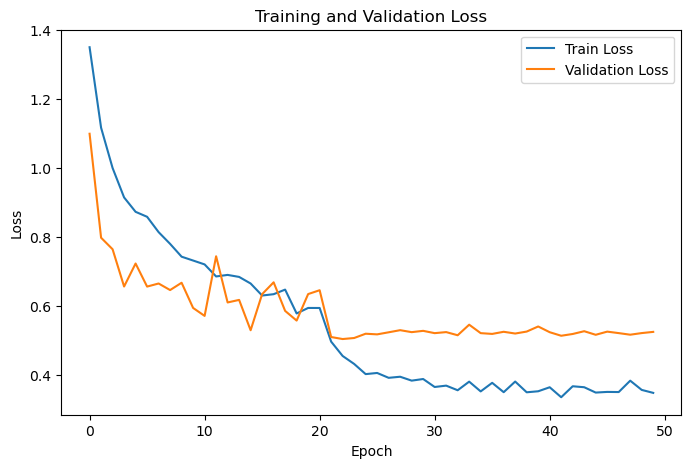

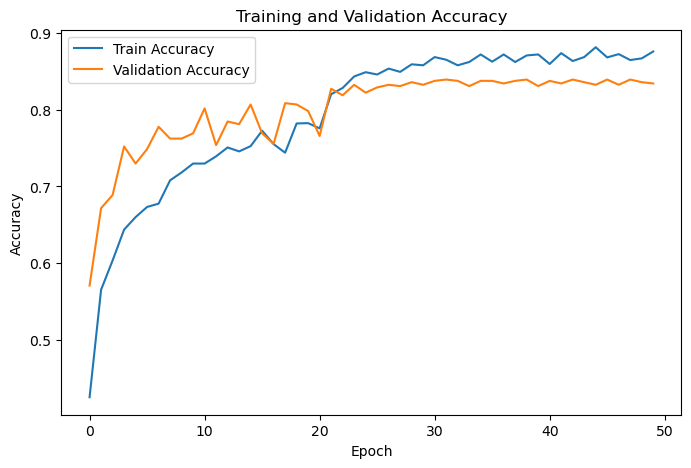

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [24]:
torch.save(trained_model.state_dict(), 'mood_recognition_model1.pth')

In [25]:
images = ['/Users/kritikasharma/Downloads/happy.jpeg',
          '/Users/kritikasharma/Downloads/Angry.jpeg',
          '/Users/kritikasharma/Downloads/sad.jpeg',
          '/Users/kritikasharma/Downloads/neautral.jpeg',
          '/Users/kritikasharma/Downloads/fear.jpeg']

In [26]:
# Load the trained model
# model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(emotion_classes))
model.load_state_dict(torch.load('/Users/kritikasharma/Downloads/mood_recognition_model1.pth', map_location=device))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

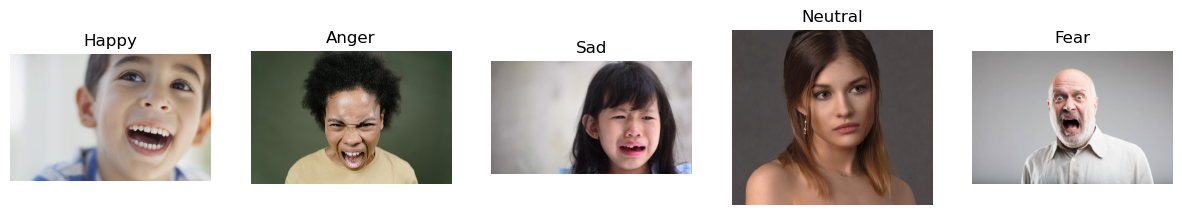

In [34]:
# Load and preprocess the input image
plt.figure(figsize=(15, 5)) 
for i, image_path in enumerate(images):
    input_image = Image.open(image_path)
    input_tensor = val_transforms(input_image).unsqueeze(0)  # Adding a batch dimension

    # Perform inference
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        output = model(input_tensor)

    # Interpret the model's output to determine the predicted emotion
    predicted_emotion_index = torch.argmax(output, dim=1).item()
    # Map the index to the corresponding emotion label 
    predicted_emotion = emotion_classes[predicted_emotion_index]

    #print("Predicted emotion:", predicted_emotion)
    # Plot the image
    plt.subplot(1, len(images), i+1)
    plt.imshow(input_image)
    plt.axis('off')

    # Write the predicted emotion on top of the image
    plt.title(predicted_emotion)

plt.show()

In [28]:
# Load face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start capturing video
cap = cv2.VideoCapture(0)

In [29]:
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check if the frame is empty
    if not ret:
        print("Error: Failed to capture frame")
        break

    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face ROI (Region of Interest)
        face_roi = gray_frame[y:y + h, x:x + w]

        # Preprocess the face ROI
        pil_image = Image.fromarray(face_roi)

        # Convert grayscale image to RGB
        pil_image_rgb = pil_image.convert('RGB')

        # Apply transformations
        input_tensor = val_transforms(pil_image_rgb).unsqueeze(0)

        # Perform inference using the model
        with torch.no_grad():
            model.eval()
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            emotion = emotion_classes[predicted.item()]

        # Draw rectangle around face and label with predicted emotion
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Display the resulting frame
    cv2.imshow('Real-time Emotion Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [30]:
# Release webcam and close windows
cap.release()
cv2.destroyAllWindows()